*IMPORTANT NOTICE*

This notebook was developed in google colab, using the colab disk space to store data. This can manipulated using bash commands, which for convience can be operated from within the notebook and are delineated clearly with exclamation marks. (e.g ! bash command)

For the model training I used the A100 GPU on colab, the following code cell shows the details of the GPU.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Mar 27 13:19:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# **Binary Training - Grayscale**

In [ ]:
#Import standard libraries and imageio to read in the images
import imageio.v3 as imageio

# Import numpy/itertools for array/maths calculations
import numpy as np
import itertools

# Import matplotlib to plot graphs etc.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

# Import pandas to manage datasets
import pandas as pd

# Import os/path lib to navigate the colab directory.
import os
import pathlib

# Import tensorflow and keras machine learning libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# Import scikit metrics to evaluate models
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import google drive mounting module
from google.colab import drive

In [2]:
# Mount Google Drive at the default location
drive.mount('/content/drive', force_remount=False)
# Define the path to your desired folder
path = '/content/drive/My Drive/2024-2025/PHAS0056/Code'
# Change to that directory
os.chdir(path)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/My Drive/2024-2025/PHAS0056/Code


In [3]:
! unzip -qq fireNoFire.zip -d /data

## **Dataset structuring**

In [4]:
# Go to the root directory
os.chdir('/')

# Create new direcory
new_dir = os.path.join(os.getcwd(), 'Binary')
os.makedirs(new_dir)

# Move to new directory
os.chdir('/Binary/')

# Create  more new direcories
new_dir = os.path.join(os.getcwd(), 'Training')
os.makedirs(new_dir)
new_dir = os.path.join(os.getcwd(), 'Test')
os.makedirs(new_dir)


# Create  more new direcories inside /Training
os.chdir('/Binary/Training')
new_dir = os.path.join(os.getcwd(), 'No_Fire')
os.makedirs(new_dir)


In [5]:
# Copy the test data labelled as 'Fire' to the new Binary/ directory
! cp -r /data/Training/Fire/ /Binary/Training/
! cp -r /data/Test/Fire /Binary/Test/

In [6]:
# Manually select mislabelled images and copy to the new /Binary/No_Fire directory
os.chdir('/Binary/Training/No_Fire')

!for i in {822..2257}; do cp "/data/Training/No_Fire/lake_resized_lake_frame$i.jpg" "/Binary/Training/No_Fire/lake_resized_lake_frame$((i + 1)).jpg"; done

!for i in {3353..5774}; do cp "/data/Training/No_Fire/lake_resized_lake_frame$i.jpg" "/Binary/Training/No_Fire/lake_resized_lake_frame$((i + 1)).jpg"; done

!for i in {6056..6656}; do cp "/data/Training/No_Fire/lake_resized_lake_frame$i.jpg" "/Binary/Training/No_Fire/lake_resized_lake_frame$((i + 1)).jpg"; done

!for i in {7837..7895}; do cp "/data/Training/No_Fire/lake_resized_lake_frame$i.jpg" "/Binary/Training/No_Fire/lake_resized_lake_frame$((i + 1)).jpg"; done

!for i in {10323..11293}; do cp "/data/Training/No_Fire/lake_resized_lake_frame$i.jpg" "/Binary/Training/No_Fire/lake_resized_lake_frame$((i + 1)).jpg"; done

# Copy original training no fire data to new directory
! cp /data/Training/No_Fire/resized_frame* /Binary/Training/No_Fire/
! cp -r /data/Test/No_Fire /Binary/Test/

# Copy over manually selected non-lake images labelled lake to the test set
os.chdir('/Binary/Test/No_Fire')

!for i in {11377..11846}; do cp "/data/Training/No_Fire/lake_resized_lake_frame$i.jpg" "/Binary/Test/No_Fire/lake_resized_lake_frame$((i + 1)).jpg"; done

In [7]:
# A non default batch size is used to address potential data imbalances (confirmed to present later)
# Define the batch size for the dataset
batch_size = 64

# Define the raw image dimensions
img_height = 254
img_width = 254

In [8]:
# Move to root directory and define training images path
os.chdir('/')
data_dir = pathlib.Path('Binary/Training')

# Use keras to load the raw training data, defining the validation split and assining binary labels to the data
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels="inferred",
  label_mode='binary',
  validation_split=0.2,
  subset="training",
  color_mode='grayscale',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 33017 files belonging to 2 classes.
Using 26414 files for training.


In [9]:
# Define the path for training images
data_dir = pathlib.Path('Binary/Training')

# Use keras to load the raw validation data, defining the validation split and assining binary labels to the data
raw_val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels="inferred",
  label_mode='binary',
  validation_split=0.2,
  subset="validation",
  color_mode='grayscale',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 33017 files belonging to 2 classes.
Using 6603 files for validation.


In [10]:
# Define the path for test images
data_dir = pathlib.Path('Binary/Test')

# Use keras to load the raw test data, defining the validation split and assining binary labels to the data
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels="inferred",
  label_mode='binary',
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 9087 files belonging to 2 classes.


In [11]:
# Print the class names
class_names = raw_train_ds.class_names
print(class_names)

['Fire', 'No_Fire']


In [ ]:
# Print the number of batches for each data subset
print("Number of training batches: %d" % tf.data.experimental.cardinality(raw_train_ds))
print("Number of validation batches: %d" % tf.data.experimental.cardinality(raw_val_ds))
print("Number of test batches: %d" % tf.data.experimental.cardinality(raw_test_ds))

Number of training batches: 413
Number of validation batches: 104
Number of test batches: 142


Fire, Count: 20016
No_Fire, Count: 6398
Total Images: 26414
Percentage of images with Fire: 75.77799651699856%
Percentage of images with No Fire: 24.22200348300144%


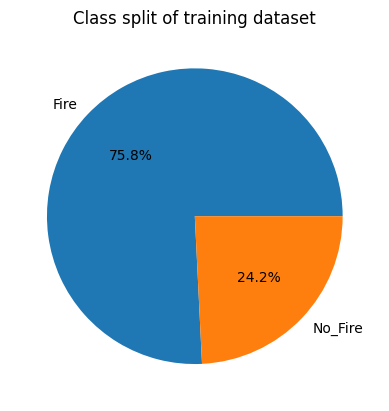

In [ ]:
# Initialize counters for both classes
Fire_count = 0
No_Fire_count = 0

# Use for loop for counting
for images, labels in raw_train_ds:
    # Convert labels to integers (0 or 1)
    labels = labels.numpy().astype(int).flatten()

    # Count how many labels are 0 and how many are 1 in the batch
    Fire_count += np.sum(labels == 0)
    No_Fire_count += np.sum(labels == 1)

# Sum the total count
Total = Fire_count + No_Fire_count

# Print out the counts
print(f"{raw_train_ds.class_names[0]}, Count: {Fire_count}")
print(f"{raw_train_ds.class_names[1]}, Count: {No_Fire_count}")
print(f"Total Images: {Total}")

# Now calculate the percentages of both classes
percent_Fire = Fire_count / Total
percent_No_Fire = No_Fire_count / Total
# Print the percentages
print(f'Percentage of images with Fire: {percent_Fire*100}%')
print(f'Percentage of images with No Fire: {percent_No_Fire*100}%')

# Creat list of percentages
sizes = [ percent_Fire,percent_No_Fire]

# Plot a pie chart of data split
plt.figure()
plt.pie(sizes,labels=class_names, autopct='%1.1f%%');
plt.title('Class split of training dataset')
plt.savefig('train_piechart.png')

Fire, Count: 5002
No_Fire, Count: 1601
Total Images: 6603
Percentage of images with Fire: 75.75%
Percentage of images with No Fire: 24.25%


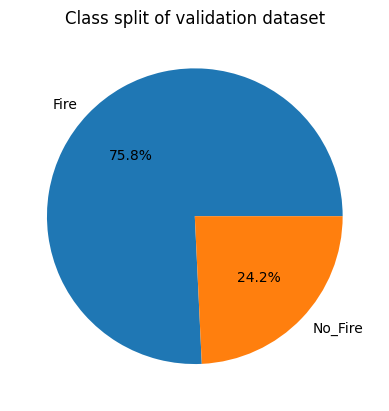

In [ ]:
# Initialize counters for both classes
Fire_count_val = 0
No_Fire_count_val = 0

# Use for loop for counting
for images, labels in raw_val_ds:
    # Convert labels to integers (0 or 1)
    labels = labels.numpy().astype(int).flatten()

    # Count how many labels are 0 and how many are 1 in the batch
    Fire_count_val += np.sum(labels == 0)
    No_Fire_count_val += np.sum(labels == 1)

# Sum the total count
Total_val = Fire_count_val + No_Fire_count_val

# Print out the counts
print(f"{raw_train_ds.class_names[0]}, Count: {Fire_count_val}")
print(f"{raw_train_ds.class_names[1]}, Count: {No_Fire_count_val}")
print(f"Total Images: {Total_val}")

# Now calculate the percentages of both classes
percent_Fire_val = Fire_count_val / (Fire_count_val + No_Fire_count_val)
percent_No_Fire_val = No_Fire_count_val / (Fire_count_val + No_Fire_count_val)

# Print the percentages
print(f'Percentage of images with Fire: {percent_Fire_val*100:.2f}%')
print(f'Percentage of images with No Fire: {percent_No_Fire_val*100:.2f}%')

# Store percentages in list
sizes_val = [ percent_Fire_val,percent_No_Fire_val]

# Plot a pie chart of data split
plt.figure()
plt.pie(sizes_val,labels=class_names, autopct='%1.1f%%');
plt.title('Class split of validation dataset')
plt.savefig('val_piechart.png')

Fire, Count: 5137
No_Fire, Count: 3950
Total Images: 9087
Percentage of images with Fire: 56.53130846263893%
Percentage of images with No Fire: 43.46869153736107%


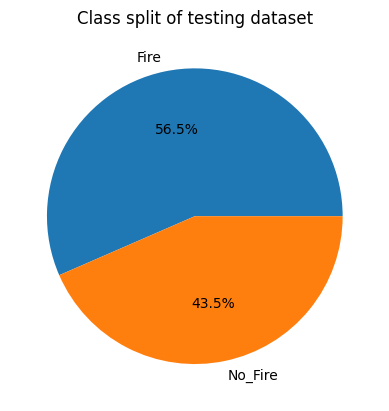

In [ ]:
# Initialize counters for both classes
Fire_count_test = 0
No_Fire_count_test = 0

# Use for loop for counting
for images, labels in raw_test_ds:
    # Convert labels to integers (0 or 1)
    labels = labels.numpy().astype(int).flatten()

    # Count how many labels are 0 and how many are 1 in the batch
    Fire_count_test += np.sum(labels == 0)
    No_Fire_count_test += np.sum(labels == 1)

# Sum the total counts
Total_test = Fire_count_test + No_Fire_count_test

# Print out the counts
print(f"{class_names[0]}, Count: {Fire_count_test}")
print(f"{class_names[1]}, Count: {No_Fire_count_test}")
print(f"Total Images: {Total_test}")

# Now calculate the percentages of both classes
percent_Fire_test = Fire_count_test / Total_test
percent_No_Fire_test = No_Fire_count_test / Total_test

# Print the percentages
print(f'Percentage of images with Fire: {percent_Fire_test*100}%')
print(f'Percentage of images with No Fire: {percent_No_Fire_test*100}%')

# Store the percentages in a list
sizes_test = [ percent_Fire_test,percent_No_Fire_test]


# Plot a pie chart of data split
plt.figure()
plt.pie(sizes_test,labels=class_names, autopct='%1.1f%%');
plt.title('Class split of testing dataset')
plt.savefig('test_piechart.png')

In [ ]:
# Create empty list to store labels
test_labels = []

# Use for loop to count
for images, labels in raw_test_ds:
    # Convert labels to integers (0 or 1)
    labels = labels.numpy().astype(int).flatten()
    # Add the labels to the list
    test_labels.extend(labels)

In [ ]:
# Print the number of testing labels
print('Number of testing images: ',len(test_labels))

Number of testing images:  9087


Add class weighting

In [ ]:
# Caclulate the weights for both classes.
weight_for_0 = (1 / Fire_count) * (Total / 2.0)
weight_for_1 = (1 / No_Fire_count) * (Total / 2.0)

# Create key-value pairs for Keras to use in training
class_weight = {0: weight_for_0, 1: weight_for_1}

# Print the class_weights
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.66
Weight for class 1: 2.06


In [ ]:
# Use the inbuilt tensforflow optimisation algorithm for prefetching and parallel calls
AUTOTUNE = tf.data.AUTOTUNE

# Define an augmentation function
def augmentation(ds, IMG_SIZE):
    '''
    Apply data augmentation techniques to an image dataset.

    Inputs:
     ds: TensorFlow dataset, the input dataset containing images.
     IMG_SIZE: int, size to which images will be resized (not used in function but typically relevant for preprocessing).

    Returns:
     ds: TensorFlow dataset, the augmented dataset with transformations applied.
    '''

    data_augmentation = tf.keras.Sequential([
        # Randomly rotate the images between -0.5 to 0.5 times 2pi
        keras.layers.RandomRotation(0.5),
        # Randomly flip the images
        keras.layers.RandomFlip("horizontal_and_vertical"),
        # Randomly change the contrast of the images
        keras.layers.RandomContrast(0.2, value_range=(0, 255)),
        # Randomly change the brightness of images
        keras.layers.RandomBrightness(0.2, value_range=(0, 255)),
        # Randomly degenerate RGB values
        # keras.layers.RandomColorDegeneration(0.2, value_range=(0, 255))
    ])

    # Apply the augmentation to the input images
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

    # Return augmentated data
    return ds

def prepare(ds, IMG_SIZE, shuffle=False, augment=False, resize=False,cache=False):
    '''
    Prepares a TensorFlow dataset with optional shuffling, augmentation, and resizing.

    Inputs:
     ds: TensorFlow dataset, the input dataset containing images.
     IMG_SIZE: int, size to which images will be resized (if resize=True).
     shuffle: bool, whether to shuffle the dataset.
     augment: bool, whether to apply data augmentation.
     resize: bool, whether to resize images to (IMG_SIZE, IMG_SIZE).

    Returns:
     ds: TensorFlow dataset, the processed dataset with applied transformations.
    '''

    # Option to shuffle the data
    if shuffle:
        ds = ds.shuffle(reshuffle_each_iteration=True)

    # Option to augment the data
    if augment:
        ds = augmentation(ds, IMG_SIZE)

    # Option to resize the data
    if resize:
        ds = ds.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y),
                    num_parallel_calls=AUTOTUNE)

    # Option to cache data
    if cache:
        ds = ds.cache()

    # Apply prefetching quality to the dataset
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the prepared dataset
    return ds


In [13]:
def visualise_samples(dataset, class_names, num_images=9, grid_size=(3, 3), figsize=(10, 10)):
    '''
    Visualises a batch of images from a TensorFlow dataset.

    Inputs:
     dataset: TensorFlow dataset, the dataset containing image-label pairs.
     class_names: list, class labels corresponding to dataset categories.
     num_images: int, number of images to display (default: 9).
     grid_size: tuple, shape of the image grid (default: (3, 3)).
     figsize: tuple, figure size for visualization (default: (10, 10)).

    Returns:
     Prints image
    '''

    #  Create figure
    plt.figure(figsize=figsize)

    # Use for loop to plot
    for images, labels in dataset.take(1):
        # For loop to take num_images
        for i in range(min(num_images, images.shape[0])):
            # Set location of plot on figure
            ax = plt.subplot(grid_size[0], grid_size[1], i + 1)
            # Display the image
            plt.imshow(images[i].numpy().astype("uint8"))
            # Add colour bar
            plt.colorbar()
            # Add class names and remove axis
            plt.title(class_names[int(labels[i])])
            plt.axis("off")



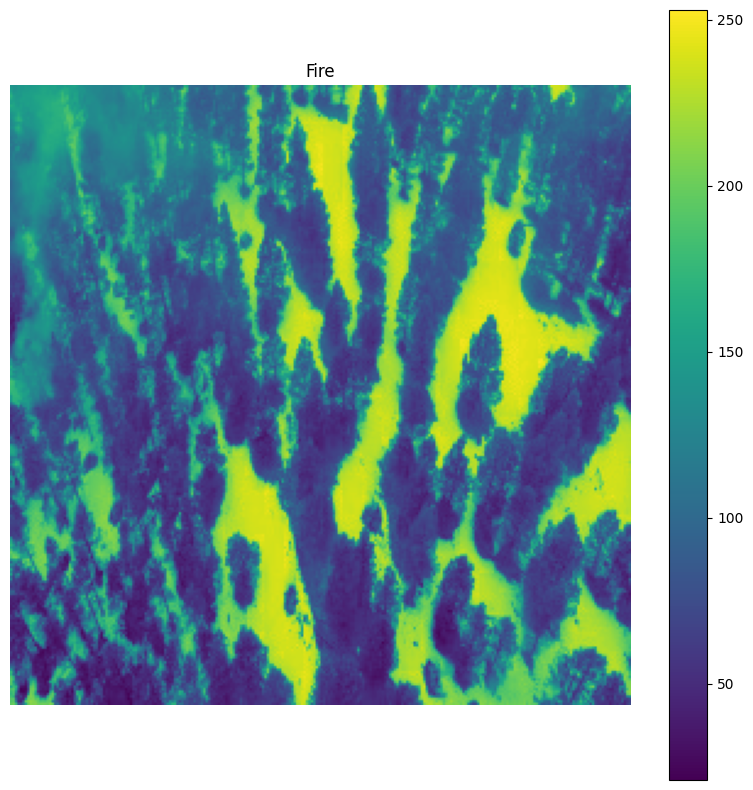

In [15]:
visualise_samples(raw_train_ds, class_names,1,(1,1,(8,8)))
plt.savefig('grayscaled.svg')

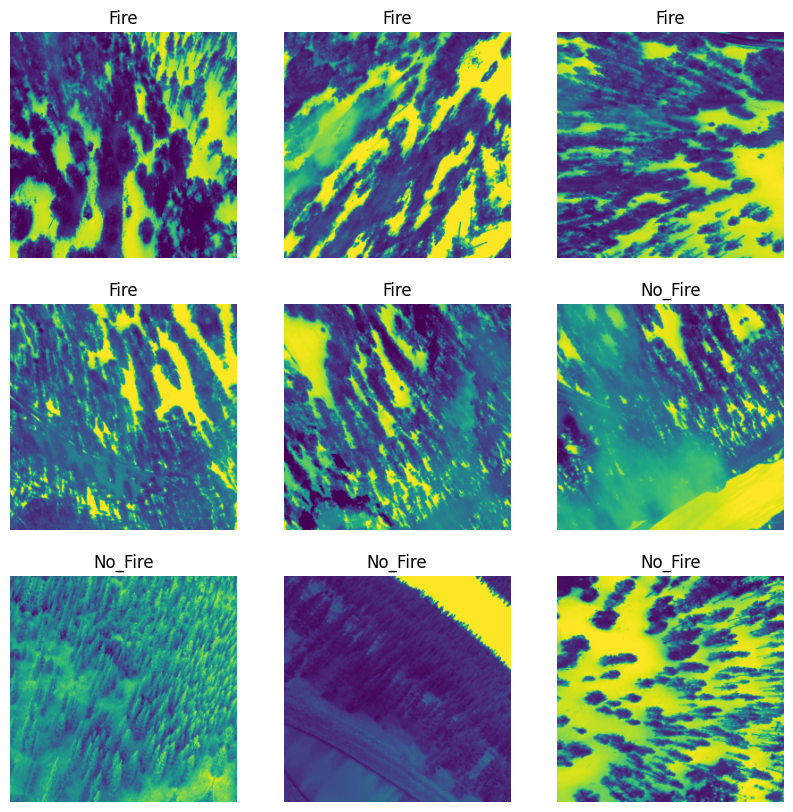

In [ ]:
IMG_SIZE = 254

aug_train_ds = prepare(raw_train_ds,IMG_SIZE,augment=True)

visualise_samples(aug_train_ds, class_names)


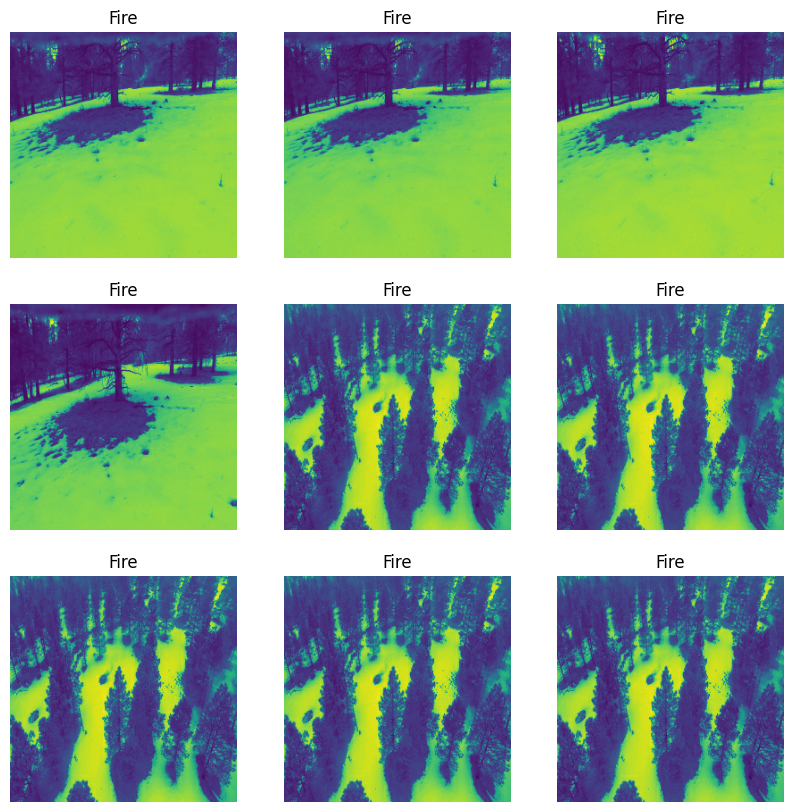

In [ ]:
visualise_samples(raw_test_ds, class_names)

In [ ]:
# Define function to reset weights for a model

def reset_weights(model):
    '''
    Resets the weights of a given Keras model.

    Inputs:
     model: Keras model, the model whose weights need to be reset.

    Returns:
     None (resets model weights in place).
    '''
    # Use for loop to apply to all layers in given model
    for layer in model.layers:
       if hasattr(layer, 'kernel_initializer'):
          layer.kernel.assign(layer.kernel_initializer(layer.kernel.shape))

# Define function which trains a model for n epochs with the option for class weighting

def train(model, train_ds, val_ds, epochs, class_weight=None):
    '''
    Trains a given Keras model.

    Inputs:
     model: Keras model, the model to train.
     train_ds: TensorFlow dataset, training dataset.
     val_ds: TensorFlow dataset, validation dataset.
     epochs: int, number of training epochs.
     class_weight: dict (optional), class weight mapping for handling imbalanced data.

    Returns:
     history: Keras History object, containing training metrics.
    '''

    # Option to use weighting
    if class_weight is None:
        hist = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=epochs)
    else:
        hist = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=epochs,
                         class_weight=class_weight)
    # Return training history
    return hist

def plot_training_binary_f1(history, modelname, epochs):
    '''
    Plots the training and validation F1 score and loss over epochs.

    Inputs:
     history: Keras History object, contains training metrics (loss, F1 score).
     modelname: str, name of the model (used for the plot title).
     epochs: int, number of training epochs.

    Returns:
     None (displays the plots).
    '''

    # Get losses
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # Get F1 scores
    acc = history.history['f1_score']
    val_acc = history.history['val_f1_score']

    # Make an array from 0 to epochs
    epoch_range = range(epochs)

    # Make subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot F1 Scores with title
    ax[0].plot(epoch_range, acc, label='Training F1 Score')
    ax[0].plot(epoch_range, val_acc, label='Validation F1 Score')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('F1 Score')
    ax[0].set_title('F1 Scores')
    ax[0].legend(edgecolor='1')

    # Plot losses with title
    ax[1].plot(epoch_range, loss, label='Training Loss')
    ax[1].plot(epoch_range, val_loss, label='Validation Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Losses')
    ax[1].legend(edgecolor='1')

    # Add title for both plots
    plt.suptitle(f'Training Metrics For {modelname}')

    # Save the plots
    plt.savefig(f'training.png')
    plt.savefig(f'training.svg')

# Define function which trains and plots history

def train_binary_f1(model, modelname, train_ds, val_ds, epochs, class_weight=None):
    '''
    Trains a binary classification model using F1 score as a key metric.

    Inputs:
     model: Keras model, the neural network to train.
     modelname: str, name of the model (used for visualization).
     train_ds: TensorFlow dataset, training dataset.
     val_ds: TensorFlow dataset, validation dataset.
     epochs: int, number of training epochs.
     class_weight: dict (optional), class weight mapping for handling imbalanced data.

    Returns:
     history: Keras History object, containing training metrics.
    '''

    # Call other functions
    history = train(model, train_ds, val_ds, epochs, class_weight)
    plot_training_binary_f1(history, modelname, epochs)

    # Return the history
    return history

In [ ]:
def binary_evaluation(ds, class_names, modelname, threshold=0.5,title=None):
    '''
    Evaluates a binary classification model and displays a confusion matrix.

    Inputs:
     ds: TensorFlow dataset, dataset containing images and labels.
     class_names: list, class labels corresponding to dataset categories.
     modelname: Keras model, trained model to evaluate.
     threshold: float, decision threshold for binary classification (default: 0.5).

    Returns:
     None (prints evaluation results and displays confusion matrix).
    '''

    # Create empty list for labels
    test_labels = []

    # Collect all labels from dataset
    for images, labels in ds:
        test_labels.extend(labels.numpy())

    print("Evaluate on test data")

    # Evaluate model performance on dataset
    results = modelname.evaluate(ds, return_dict=True)
    print("Test loss, test accuracy:", results)

    # Generate predictions for the dataset
    predictions = modelname.predict(ds)

    # Apply threshold to convert probabilities into binary class labels
    predicted_classes = (predictions >= threshold).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_true=test_labels, y_pred=predicted_classes)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)

    # Option for title
    if title is not None:
        plt.title(title)

    # Save Confusion matrix
    plt.savefig(f'Confusion.svg')


def plot_ROC_curve(modelname, test_ds, test_labels,title=None):
    '''
    Plots the ROC curve and calculates the optimal threshold using Youden's J statistic.

    Inputs:
      modelname: Keras model, the trained model to evaluate.
      test_ds: TensorFlow dataset, dataset containing test images and labels.
      test_labels: list or array, true binary labels for the test dataset.

    Returns:
      None (displays the ROC curve and prints the optimal threshold).
    '''

    # Get model predictions for the test dataset
    pred = modelname.predict(test_ds)

    # Calculate the ROC curve values (False Positive Rate, True Positive Rate, and thresholds)
    fpr, tpr, thresholds = roc_curve(test_labels, pred)

    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')  # Diagonal line representing no skill
    plt.xlim([0.0, 1.0])  # X-axis limits (False Positive Rate)
    plt.ylim([0.0, 1.05])  # Y-axis limits (True Positive Rate)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()


    # Option for title
    if title is not None:
        plt.title(title)


    # Calculate Youden's J statistic (TPR - FPR)
    J_scores = tpr - fpr

    # Find the index of the optimal threshold (maximum J score)
    optimal_idx = np.argmax(J_scores)

    # Get the optimal threshold value
    optimal_threshold = thresholds[optimal_idx]

    # Print the optimal threshold
    print("Optimal Threshold:", optimal_threshold)

    # Save the ROC curve
    plt.savefig(f'ROC.svg')


In [ ]:
# Prepare training/validation datasets
train_ds = prepare(raw_train_ds,IMG_SIZE,augment=True,cache=True)
val_ds = prepare(raw_val_ds,IMG_SIZE)

In [ ]:
# Define metrics
METRICS = [
      keras.metrics.F1Score(name='f1_score',threshold=(0.5)),
      keras.metrics.AUC(name='auc'),
]

In [ ]:
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / Fire_count) * (Total / 2.0)
weight_for_1 = (1 / No_Fire_count) * (Total / 2.0) * 1.3

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.66
Weight for class 1: 2.68


## **Model Training**

In [ ]:

def make_model(summarise='False'):
    '''
    Builds and compiles a CNN model for binary classification.

    Inputs:
      summarise: bool, whether to print the model summary (default is False).

    Returns:
      model: Compiled Keras model.
    '''
    model = keras.Sequential([
      keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 1)),
      keras.layers.Conv2D(32, 3, padding='same'),
      keras.layers.LeakyReLU(alpha=0.1),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(64, 3, padding='same'),
      keras.layers.LeakyReLU(alpha=0.1),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(64, 3, padding='same'),
      keras.layers.LeakyReLU(alpha=0.1),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(32, 3, padding='same'),
      keras.layers.LeakyReLU(alpha=0.1),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(32),
      keras.layers.LeakyReLU(alpha=0.1),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

    if summarise == 1:
      model.summary()
      return model
    else:
      return model


In [ ]:
model = make_model(1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 254, 254, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 254, 254, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 127, 127, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 127, 127, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 63, 63, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 31, 31, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 31, 31, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │         230,432 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 305,441 (1.17 MB)

 Trainable params: 305,057 (1.16 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
reset_weights(model)

Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - auc: 0.9351 - f1_score: 0.7811 - loss: 0.3985 - val_auc: 0.9326 - val_f1_score: 0.7753 - val_loss: 0.3870
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - auc: 0.9803 - f1_score: 0.8832 - loss: 0.1930 - val_auc: 0.9910 - val_f1_score: 0.9425 - val_loss: 0.0877
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - auc: 0.9906 - f1_score: 0.9224 - loss: 0.1333 - val_auc: 0.9223 - val_f1_score: 0.8074 - val_loss: 0.4932
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - auc: 0.9965 - f1_score: 0.9474 - loss: 0.0773 - val_auc: 0.9904 - val_f1_score: 0.9338 - val_loss: 0.0930
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - auc: 0.9981 - f1_score: 0.9627 - loss: 0.0567 - val_auc: 0.9931 - val_f1_score: 0.9491 - val_loss: 0.0730
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - auc: 0.9994 - f1_score: 0.9785 - loss: 0.0345 - val_auc: 0.9803 - val_f1_score: 0.9262 - val_loss: 0.1567
Epoch 7/100
413/413 ━━

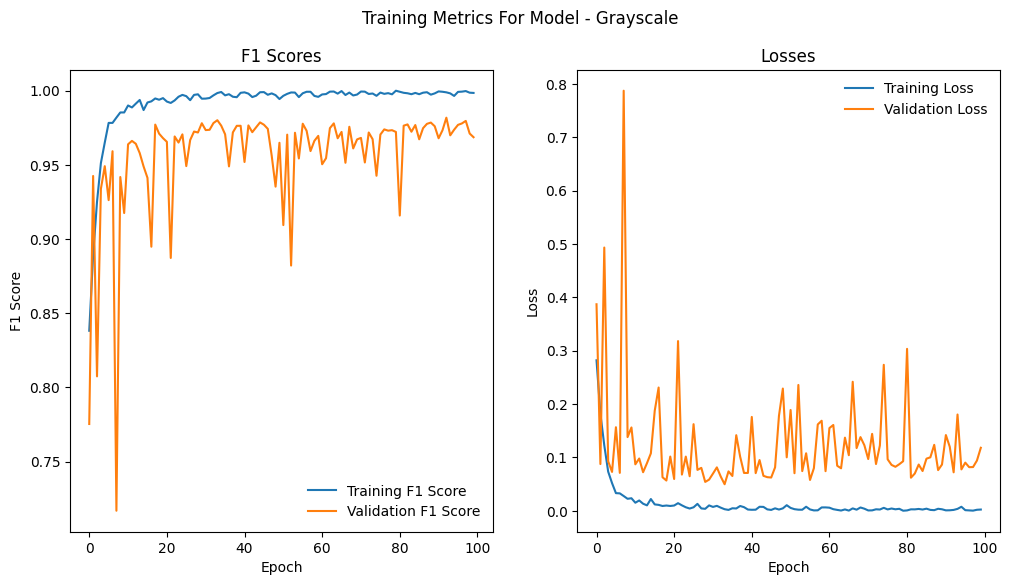

In [ ]:
history_grayscale = train_binary_f1(model,'Model - Grayscale',train_ds,val_ds,100,class_weight)

Evaluate on test data
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.3249 - f1_score: 0.2239 - loss: 2.0545
Test loss, test accuracy: {'auc': 0.6748190522193909, 'f1_score': 0.5454825162887573, 'loss': 3.649484634399414}
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


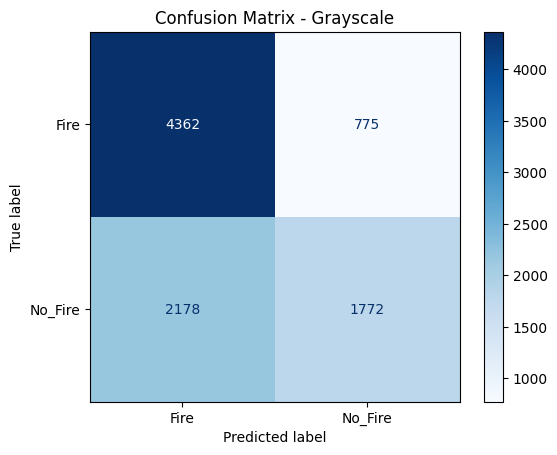

In [ ]:
binary_evaluation(raw_test_ds,class_names,model,title='Confusion Matrix - Grayscale')

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Optimal Threshold: 7.701379e-07


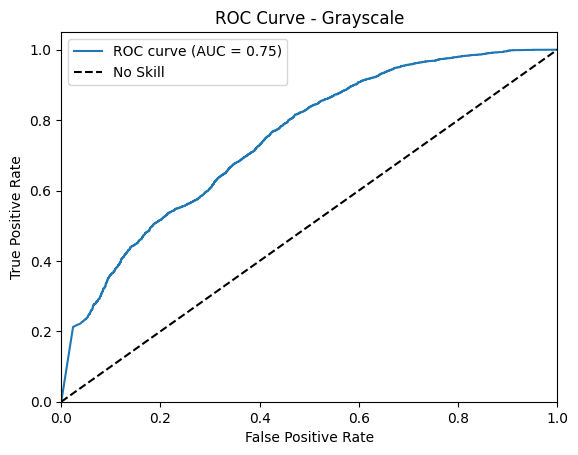

In [ ]:
plot_ROC_curve(model,raw_test_ds,test_labels,title='ROC Curve - Grayscale')

In [ ]:
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / Fire_count) * (Total / 2.0)
weight_for_1 = (1 / No_Fire_count) * (Total / 2.0) * 1.75

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.66
Weight for class 1: 3.61


In [ ]:
model_2 = make_model(1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 254, 254, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 254, 254, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 127, 127, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 127, 127, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 63, 63, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 31, 31, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 31, 31, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │         230,432 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 305,441 (1.17 MB)

 Trainable params: 305,057 (1.16 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - auc: 0.8245 - f1_score: 0.7269 - loss: 0.4662 - val_auc: 0.4989 - val_f1_score: 0.3903 - val_loss: 8.2080
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - auc: 0.9775 - f1_score: 0.8846 - loss: 0.2373 - val_auc: 0.9863 - val_f1_score: 0.8831 - val_loss: 0.2026
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - auc: 0.9883 - f1_score: 0.9070 - loss: 0.1739 - val_auc: 0.9830 - val_f1_score: 0.9308 - val_loss: 0.1229
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - auc: 0.9920 - f1_score: 0.9299 - loss: 0.1356 - val_auc: 0.9716 - val_f1_score: 0.7928 - val_loss: 0.4133
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - auc: 0.9947 - f1_score: 0.9443 - loss: 0.1099 - val_auc: 0.9907 - val_f1_score: 0.8647 - val_loss: 0.2007
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - auc: 0.9969 - f1_score: 0.9543 - loss: 0.0818 - val_auc: 0.9965 - val_f1_score: 0.9412 - val_loss: 0.0978
Epoch 7/100
413/413 ━━

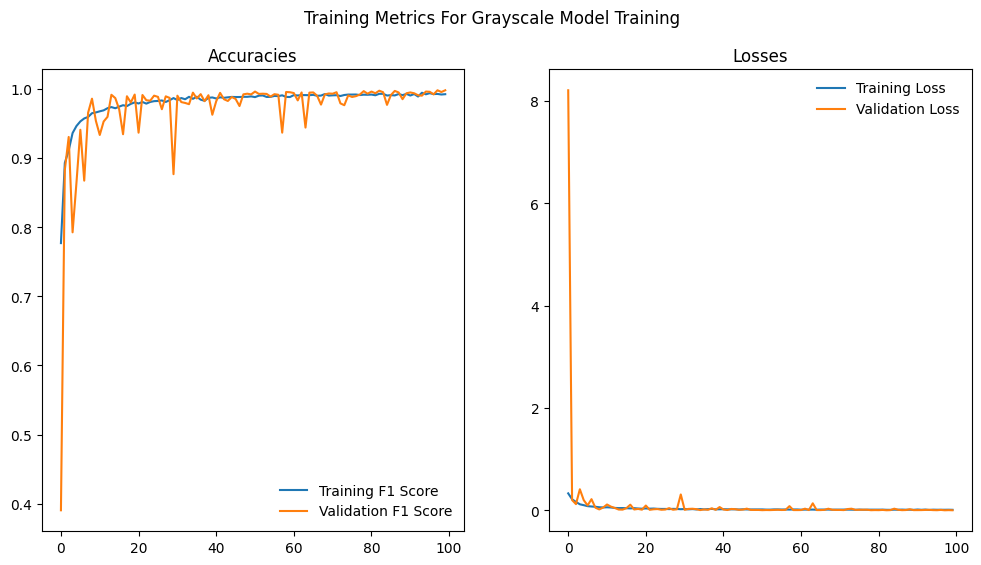

In [ ]:
history_2 = train_binary_f1(model_2,'Grayscale Model Training',train_ds,val_ds,100,class_weight)

Evaluate on test data
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.3440 - f1_score: 0.2080 - loss: 0.8345
test loss, test acc: {'auc': 0.7325555086135864, 'f1_score': 0.4370836615562439, 'loss': 2.245884895324707}
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


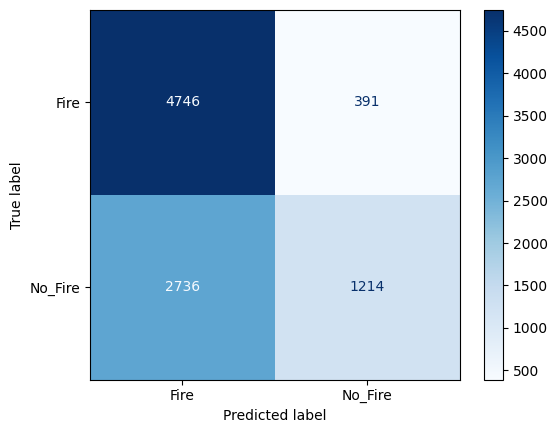

In [ ]:
binary_evaluation(raw_test_ds,class_names,model_2)

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Optimal Threshold: 0.00010279329


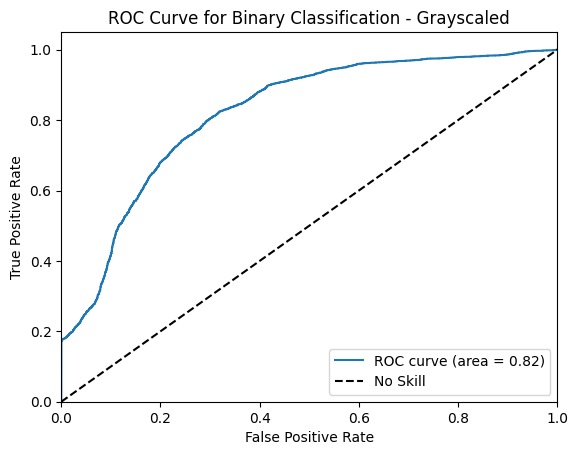

In [ ]:
plot_ROC_curve(model_2,raw_test_ds,test_labels,'ROC Curve for Binary Classification - Grayscaled')

Evaluate on test data
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.3440 - f1_score: 0.2080 - loss: 0.8345
test loss, test acc: {'auc': 0.7325555086135864, 'f1_score': 0.4370836615562439, 'loss': 2.245884895324707}
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


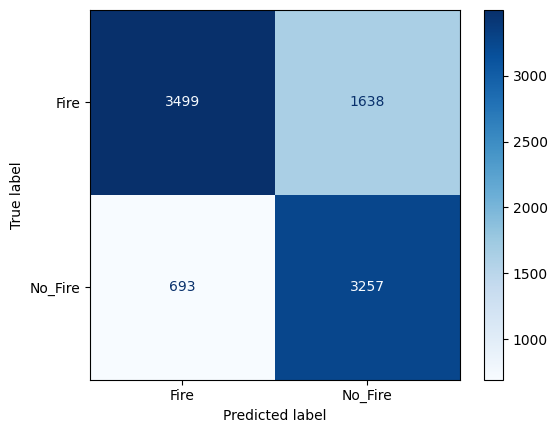

In [ ]:
binary_evaluation(raw_test_ds,class_names,model_2,0.00010279329)

In [ ]:
model.save_weights('my_model.weights.h5') # Saves the model weights as 'my_model_weights.h5'

## **No augmentation**

In [ ]:
train_ds = prepare(raw_train_ds,IMG_SIZE)
val_ds = prepare(raw_val_ds,IMG_SIZE)

In [ ]:
model_3 = make_model(1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 254, 254, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 254, 254, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 127, 127, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 127, 127, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 63, 63, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 31, 31, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18 (LeakyReLU)           │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 31, 31, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │         230,432 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 305,441 (1.17 MB)

 Trainable params: 305,057 (1.16 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - auc: 0.8365 - f1_score: 0.6830 - loss: 0.1185 - val_auc: 0.5017 - val_f1_score: 0.3903 - val_loss: 10.5364
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - auc: 0.9993 - f1_score: 0.9900 - loss: 0.0150 - val_auc: 0.9994 - val_f1_score: 0.9902 - val_loss: 0.0151
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - auc: 0.9995 - f1_score: 0.9911 - loss: 0.0130 - val_auc: 0.9963 - val_f1_score: 0.9883 - val_loss: 0.0338
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - auc: 0.9993 - f1_score: 0.9958 - loss: 0.0114 - val_auc: 1.0000 - val_f1_score: 0.9975 - val_loss: 0.0038
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - auc: 0.9994 - f1_score: 0.9962 - loss: 0.0083 - val_auc: 0.9975 - val_f1_score: 0.9845 - val_loss: 0.0239
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - auc: 0.9999 - f1_score: 0.9975 - loss: 0.0031 - val_auc: 0.9956 - val_f1_score: 0.9832 - val_loss: 0.0391
Epoch 7/100
413/413 ━━━━━━

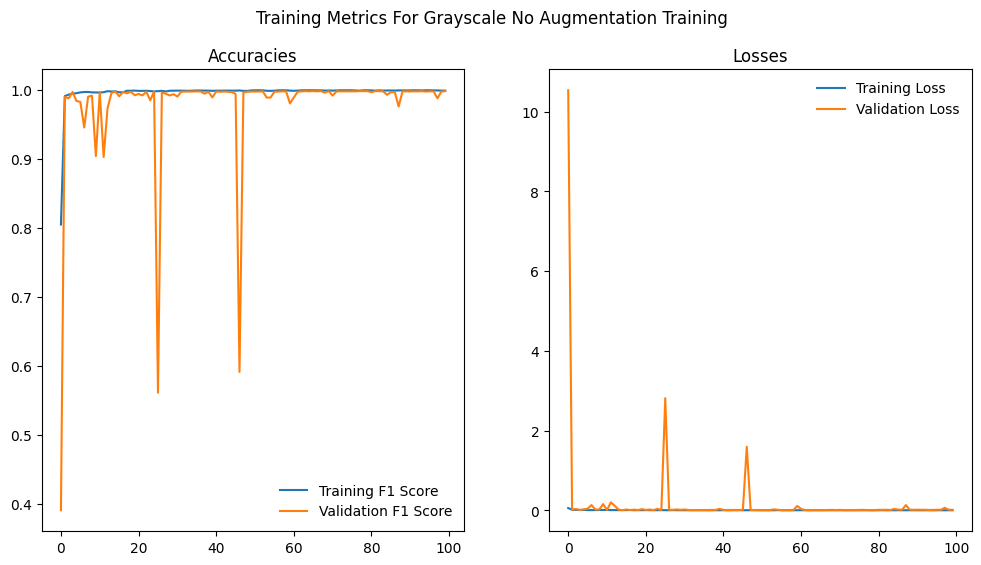

In [ ]:
history_3 = train_binary_f1(model_3,'Grayscale No Augmentation Training',train_ds,val_ds,100)

Evaluate on test data
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - auc: 0.2929 - f1_score: 0.1822 - loss: 6.6571
test loss, test acc: {'auc': 0.5830767750740051, 'f1_score': 0.44046521186828613, 'loss': 10.651522636413574}
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


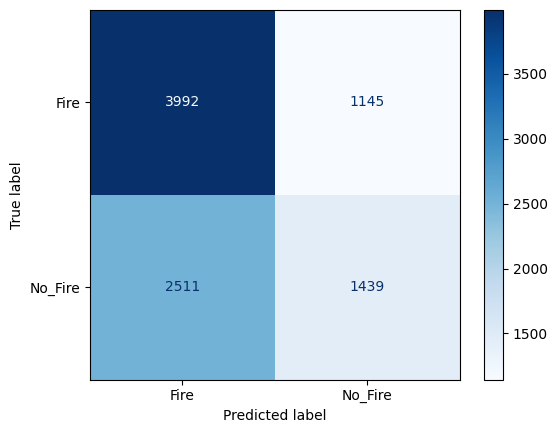

In [ ]:
binary_evaluation(raw_test_ds,class_names,model_3)

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Optimal Threshold: 1.888445e-11


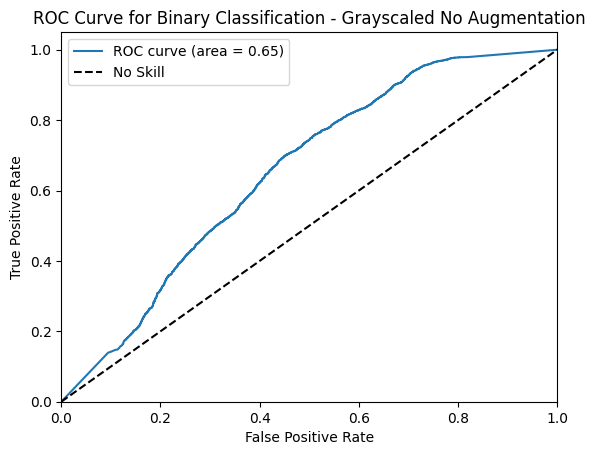

In [ ]:
plot_ROC_curve(model_3,raw_test_ds,test_labels,'ROC Curve for Binary Classification - Grayscaled No Augmentation')

## **Conclusiom**

Whilst model training decreased, there was a fairly signifcant loss in F1 score. The model perhaps requires the seperated RGB channels to accurately extract features from the images.